Goal: Understand why ROC-AUC is a poor metric for evaluating a model's performance when classes are highly imbalanced

References:
1. [The relationship between precision-recall and roc curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)
2. [Introduction to ROC Analysis by Tom Fawcett](https://www.sciencedirect.com/science/article/abs/pii/S016786550500303X)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [40]:
def gen_data(pos_weight):
    X, y = datasets.make_classification(
    n_samples=10000, 
    n_classes=2, 
    weights=[1 - pos_weight, pos_weight], 
    random_state=42
    )
    return X, y

In [2]:
def gen_prediction_probabilities(model, testX):
    '''Generate prediction probabilities for each class
    
    Probabilities of positive class is in the 2nd column
    '''
    pred_proba_1d = model.predict_proba(testX)[:, 1]
    pred_proba_1d = pred_proba_1d.reshape((pred_proba_1d.shape[0],1))
    pred_proba = np.append(1 - pred_proba_1d, pred_proba_1d, axis=1)
    return pred_proba

In [3]:
def gen_predictions(pred_proba, thresh=0.5):
    return (pred_proba[:, 1] > thresh).astype(int)

In [34]:
def gen_confusion_matrix(testy, pred_proba):
    return pd.crosstab(
        gen_predictions(pred_proba), testy, 
        rownames=['Predicted'], 
        colnames=['Actual'], 
        margins=True)

In [5]:
def compute_scores(testy, predictions, pred_proba):
    return (
        f" Acc: {accuracy_score(testy, predictions):.3f} | "
        f"ROC-AUC: {roc_auc_score(testy, pred_proba[:,1]):.3f} | "
        f"F1: {f1_score(testy, predictions):.3f}"
    )

In [6]:
def plots(testy, pred_proba):
    '''Plot ROC, Precision-Recall, and Cumulative Gains curves'''
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax_roc = skplt.metrics.plot_roc(
        testy, pred_proba, 
        plot_micro=False, plot_macro=False,
        classes_to_plot=[1],
        ax=ax[0]
    );
    ax_pr = skplt.metrics.plot_precision_recall(
        testy, pred_proba,
        plot_micro=False,
        classes_to_plot=[1],
        ax=ax[1]
    );
    ax_cumgain = skplt.metrics.plot_cumulative_gain(
        testy, pred_proba,
        ax=ax[2]
    );
    

In [49]:
X, y = gen_data(pos_weight=0.01)
trainX, testX, trainy, testy = train_test_split(
    X, y, test_size=0.2, random_state=2)

In [50]:
# Models
m1 = LogisticRegression(random_state=42)
m1.fit(trainX, trainy);

m2 = DummyClassifier(strategy='most_frequent', random_state=42)
m2.fit(trainX, trainy);

/Users/palermopenano/miniconda3/envs/cpa/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [51]:
def evaluate_model(m):
    print(">>> Model:", m.__class__)
    
    print(f">>> Class ratio (neg to pos) {(testy.shape[0] - testy.sum()) / testy.sum():.1f}:1")
    
    print(">>> Confusion Matrix")
    pred_proba = gen_prediction_probabilities(m, testX)
    display(gen_confusion_matrix(testy, pred_proba))   

    print(">>> Scores")
    predictions = gen_predictions(pred_proba)
    print(compute_scores(testy, predictions, pred_proba))
    
    print(">>> Plots")
    plots(testy, pred_proba)
    plt.show()

>>> Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
>>> Class ratio (neg to pos) 75.9:1
>>> Confusion Matrix


Actual,0,1,All
Predicted,,,
0,1973,26,1999
1,1,0,1
All,1974,26,2000


>>> Scores
 Acc: 0.987 | ROC-AUC: 0.775 | F1: 0.000
>>> Plots


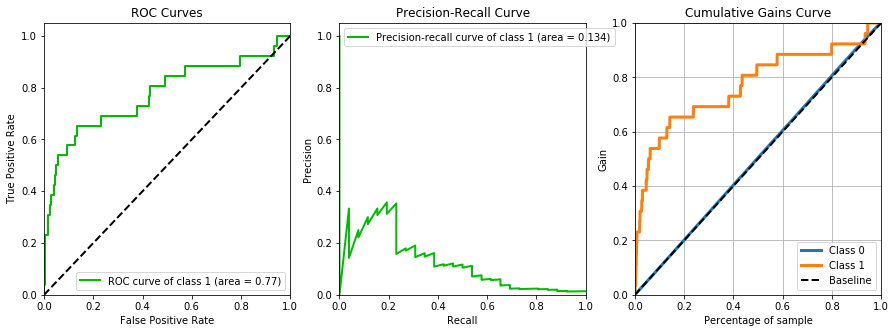

In [52]:
evaluate_model(m1)

### Important points:
* ROC represents the trade-off between hit-rate (TPR) and false-alarm rate (FPR). 
    * If we want a model with liberal classification rules to capture as many positive classes as possible, we must live with a high rate of false positives.
    * A model along the 45-degree line is as good as a model that chooses a class at random (it gets a positive class right as often as it gets it wrong (e.g. false positive))
* Use ROC-AUC if both positive and negative classes are important (e.g. interested in our model classifying both cats AND dogs as opposed to classifying cats (the positive class) and not-cats). 
* Use precision-recall curve if we only care about positive classes. In such case, we want to know how often a case is actually a fraud given that our model classified it as a fraud (precision) AND among all frauds in the test set, how many was our model able to capture with a correct classification
    * Using PR curve becomes important in imbalance class problems because in such problems, we typically only care about the minority class (e.g fraud cases, diagnosed with cancer cases, etc.)
    * ROC curves fails when the class distribution is imbalanced because the ROC curve does not change (for a given model) even if the class distribution of the test set becomes drastically imbalanced (see figure 5 in Intro to ROC by Fawcet)
    * Why does the ROC curve still bow to the upper left corner with class imbalance ???